In [1]:
import numpy as np
import elasticdeform as ed
import cv2
import math
import copy
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ShuffleSplit

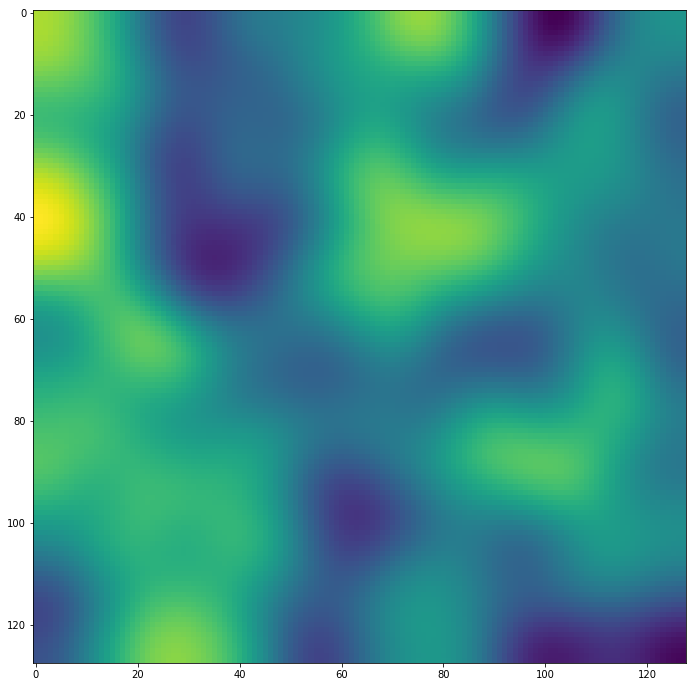

In [2]:
plt.figure(figsize=(12,12))
random = np.random.randn(128, 128)
blur_sigma = 51
blur = cv2.GaussianBlur(random,(blur_sigma, blur_sigma), 0)
plt.imshow(blur)

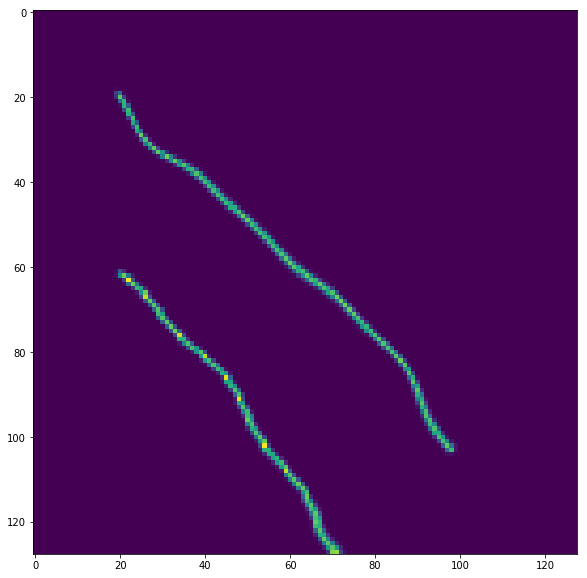

In [3]:
canvas = np.zeros((128, 128))
line = canvas
cv2.line(line, (20, 20), (100, 100), color=(255,), thickness=1, lineType=cv2.LINE_AA)
cv2.line(line, (20, 60), (100, 160), color=(255,), thickness=1, lineType=cv2.LINE_AA)
line_distorted = ed.deform_random_grid(line, sigma=2, points=10, prefilter=False)
plt.figure(figsize=(12, 10))
plt.imshow(line_distorted)

6


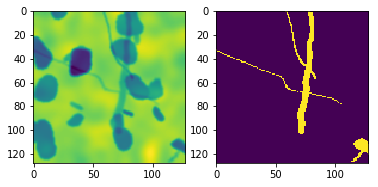

In [4]:
class ImageGenerator:
    def __init__(self):
        self.size_x = 128
        self.size_y = 128
        self.range_canvas = (0, 127)
        self.mu_n_lines = 4
        self.mu_n_noise = 20
        self.mu_len_line = math.sqrt(self.size_x**2 + self.size_y**2) * 2
        self.mu_len_noise = math.sqrt(self.size_x**2 + self.size_y**2) * 0.05
        self.mu_color_background = 127
        self.mu_color_line = 96
        self.mu_color_noise = 96
        self.mu_thickness_line = 1
        self.mu_thickness_noise = 3
        self.sigma_blur_background = 31
        self.sigma_blur_lines = 3
        self.sigma_blur_noise = 3
        self.sigma_color_background = 255
        self.sigma_color_line = 36
        self.sigma_color_noise = 36
        self.sigma_n_lines = 3
        self.sigma_n_noise = 3
        self.sigma_len_line = math.sqrt(self.size_x**2 + self.size_y**2) * 0.1
        self.sigma_len_noise = math.sqrt(self.size_x**2 + self.size_y**2) * 0.02
        self.sigma_thickness_line = 4
        self.sigma_thickness_noise = 20
        self.sigma_deformation = 2
        self.points_deformation = 10
        self.margin_ratio = 0.1
        self.tresh_true = 30
        self.color_delta = 5
    
    def _random_line(self, sigma_len, mu_len, sigma_color, mu_color, size_x, size_y, margin_ratio,
                     mu_thickness, sigma_thickness, sigma_deformation, points_deformation,
                     min_color=0):
        len_line = max(0, np.random.randn(1)[0]*sigma_len + mu_len)
        color_line = int(max(min_color, np.random.randn(1)[0]*sigma_color + mu_color))
        point_start = (
                       int(np.random.rand(1)[0] * size_x * (1 + margin_ratio*2) - 
                           self.size_x*self.margin_ratio), \
                       int(np.random.rand(1)[0] * size_y * (1 + margin_ratio*2) - 
                           self.size_x*self.margin_ratio)
                      )
        phi = np.random.rand(1)[0] * math.pi * 2
        dx = int(math.cos(phi) * len_line)
        dy = int(math.sin(phi) * len_line)
        point_end = (point_start[0] + dx, point_start[1] + dy)
        thickness_line = int(max(0, np.random.rand(1)[0]*sigma_thickness +
                                 self.mu_thickness_line))

        image_line = np.zeros((self.size_x, self.size_y))
        cv2.line(image_line, point_start, point_end, color=(color_line,),
                 thickness=thickness_line, lineType=cv2.LINE_AA)
        image_line = ed.deform_random_grid(image_line, sigma=sigma_deformation,
                                           points=points_deformation, prefilter=False)
        return image_line
    
    def generate(self, size_x=128, size_y=128):
        image_random = np.random.randn(self.size_x, self.size_y)*self.sigma_color_background
        image_random += self.mu_color_background
        image_random[image_random < 0] = 0
        image_blurred = cv2.GaussianBlur(image_random, (self.sigma_blur_background,
                                                        self.sigma_blur_background), 0)

        image_result = image_blurred
        image_lines = np.zeros((self.size_x, self.size_y))
        n_lines = max(0, int(np.random.randn(1) * self.sigma_n_lines) + self.mu_n_lines)
        print(n_lines)
        for line_n in range(n_lines):
            image_line = self._random_line(self.sigma_len_line, self.mu_len_line, self.sigma_color_line,
                                           self.mu_color_line, self.size_x, self.size_y, self.margin_ratio,
                                           self.mu_thickness_line, self.sigma_thickness_line,
                                           self.sigma_deformation, self.points_deformation,
                                           min_color=self.tresh_true + self.color_delta)
            image_lines = np.maximum(image_lines, image_line)
        image_lines_blurred = cv2.GaussianBlur(image_lines, (self.sigma_blur_lines,
                                                             self.sigma_blur_lines), 0)

        image_noise = np.zeros((size_x, size_y))
        n_noise = max(0, int(np.random.randn(1) * self.sigma_n_noise) + self.mu_n_noise)
        for noise_n in range(n_noise):
            image_bit = self._random_line(self.sigma_len_noise, self.mu_len_noise, self.sigma_color_noise,
                                            self.mu_color_noise, self.size_x, self.size_y, 0,
                                            self.mu_thickness_noise, self.sigma_thickness_noise,
                                            self.sigma_deformation, self.points_deformation)
            image_noise = np.maximum(image_noise, image_bit)
        image_noise_blurred = cv2.GaussianBlur(image_noise, (self.sigma_blur_noise,
                                                             self.sigma_blur_noise), 0)

        image_result = image_result - image_lines_blurred - image_noise_blurred
        image_true = copy.deepcopy(image_lines)
        image_true[image_true > self.tresh_true] = 255
        image_true[image_true <= self.tresh_true] = 0
        
        return image_result, image_true
    
ig = ImageGenerator()
image_result, image_true = ig.generate()
plt.figure()
plt.subplot(121)
plt.imshow(image_result)
plt.subplot(122)
plt.imshow(image_true)

In [5]:
ig = ImageGenerator()
ig.mu_n_noise = 0
ig.sigma_n_noise = 0
dataset_positive = []
for i in range(50):
    dataset_positive.append(ig.generate())

ig = ImageGenerator()
ig.mu_n_lines = 0
ig.sigma_n_lines = 0
dataset_negative = []
for i in range(50):
    dataset_negative.append(ig.generate())

dataset = dataset_positive + dataset_negative
dataset = np.array(dataset)

3
6
7
5
4
6
4
4
4
4
10
7
3
3
4
2
0
0
4
9
2
0
3
4
2
4
8
0
5
4
4
5
3
4
3
6
6
7
3
3
1
3
0
3
4
0
9
4
0
8
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


In [6]:
rs = ShuffleSplit(n_splits=1, test_size=.3, random_state=0)
train_indices, test_indices = list(rs.split([dataset[i][0] for i in range(len(dataset))]))[0]
X = dataset[:, 0, :, :]
X = np.reshape(X, X.shape + (1,))
Y = dataset[:, 1, :, :] > 127
Y = np.reshape(Y, Y.shape + (1,))

In [7]:
X_train = X[train_indices]
X_test = X[test_indices]
Y_train = Y[train_indices]
Y_test = Y[test_indices]

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label


from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 1
TRAIN_PATH = './samples/in/'
TEST_PATH = './samples/out/'

seed = 42
np.random.seed = seed

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[mean_iou])
model.summary()

Using TensorFlow backend.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 128, 128, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 128, 128, 16) 0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (

In [9]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-dsbowl2018-1.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.3, batch_size=1, epochs=20, 
                    callbacks=[earlystopper, checkpointer])
Y_predicted = model.predict(X_test)

Train on 49 samples, validate on 21 samples
Epoch 1/20
49/49 [==============================] - 17s 341ms/step - loss: 0.1168 - mean_iou: 0.4794 - val_loss: 0.0912 - val_mean_iou: 0.4884

Epoch 00001: val_loss improved from inf to 0.09125, saving model to model-dsbowl2018-1.h5
Epoch 2/20
49/49 [==============================] - 10s 210ms/step - loss: 0.1017 - mean_iou: 0.4884 - val_loss: 0.0830 - val_mean_iou: 0.4897

Epoch 00002: val_loss improved from 0.09125 to 0.08298, saving model to model-dsbowl2018-1.h5
Epoch 3/20
49/49 [==============================] - 11s 225ms/step - loss: 0.0954 - mean_iou: 0.4898 - val_loss: 0.1067 - val_mean_iou: 0.4914

Epoch 00003: val_loss did not improve from 0.08298
Epoch 4/20
49/49 [==============================] - 12s 238ms/step - loss: 0.0933 - mean_iou: 0.4915 - val_loss: 0.0751 - val_mean_iou: 0.4924

Epoch 00004: val_loss improved from 0.08298 to 0.07512, saving model to model-dsbowl2018-1.h5
Epoch 5/20
49/49 [==============================] -

/home/gleps/programs/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


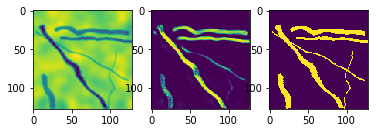

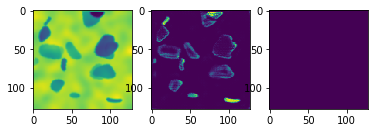

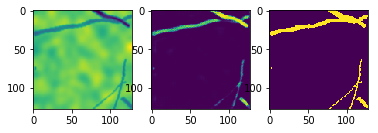

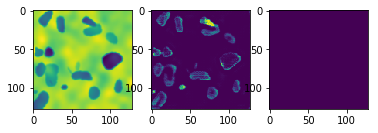

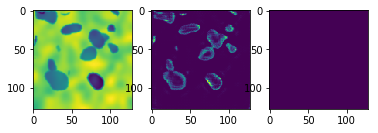

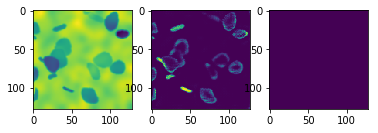

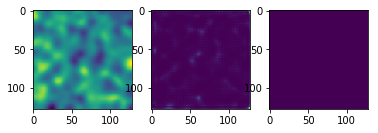

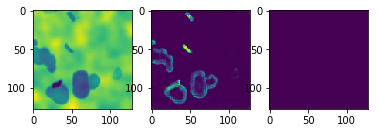

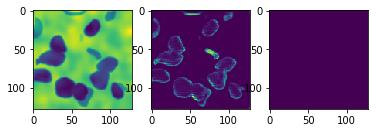

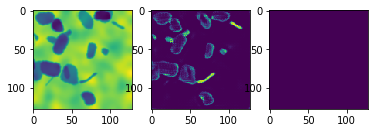

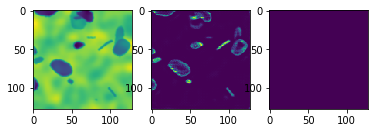

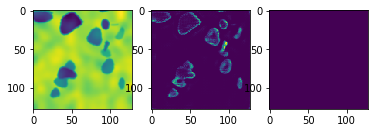

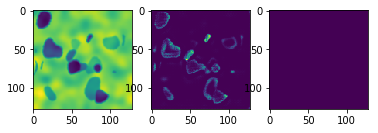

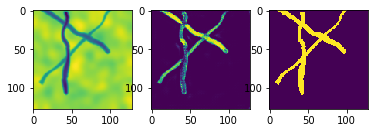

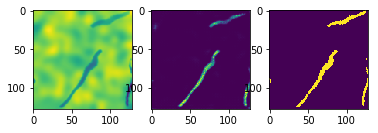

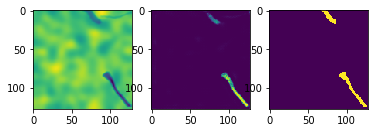

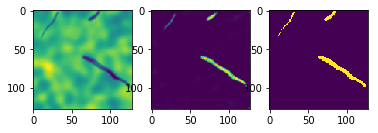

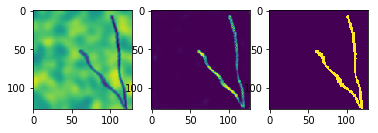

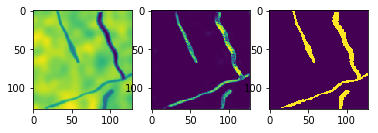

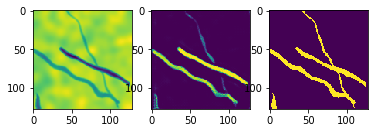

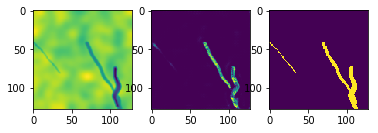

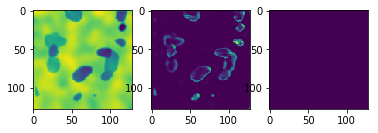

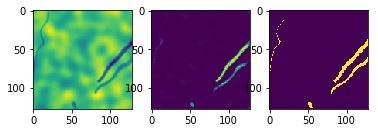

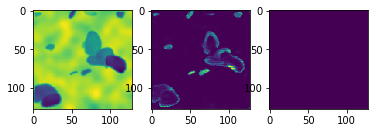

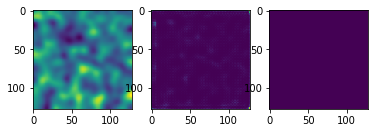

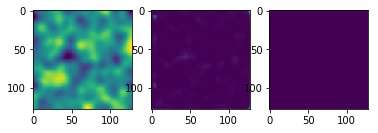

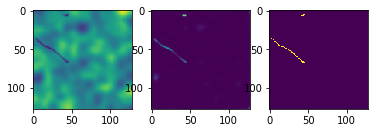

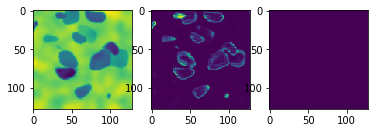

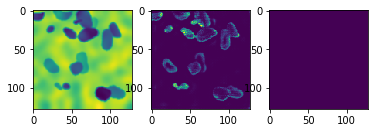

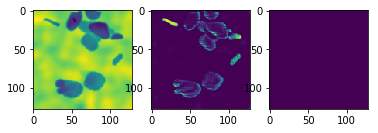

In [10]:
for i in range(X_test.shape[0]):
    plt.figure()
    plt.subplot(131)
    plt.imshow(X_test.squeeze()[i])
    plt.subplot(132)
    plt.imshow(Y_predicted.squeeze()[i])
    plt.subplot(133)
    plt.imshow(Y_test.squeeze()[i])

In [11]:
images_names_in = os.listdir(TRAIN_PATH)
images_names_out = os.listdir(TEST_PATH)
images_in = []
images_in = []
images_out = []
images_out = []
for image_name in (images_names_in):
    tmp = cv2.cvtColor(plt.imread(TRAIN_PATH + image_name), cv2.COLOR_BGR2GRAY)
    tmp = np.reshape(tmp, tmp.shape + (1,))
    images_in.append(tmp)
for image_name in (images_names_out):
    tmp = cv2.cvtColor(plt.imread(TEST_PATH + image_name), cv2.COLOR_BGR2GRAY)
    tmp = np.reshape(tmp, tmp.shape + (1,))
    images_out.append(tmp)
images_in = np.asarray(images_in)
images_out = np.asarray(images_out)

In [12]:
Y_realworld = model.predict(images_in)

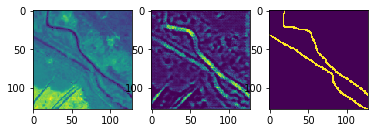

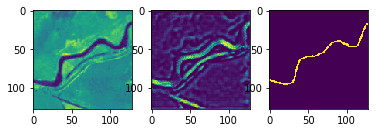

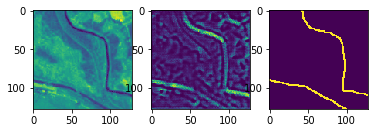

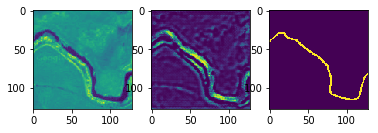

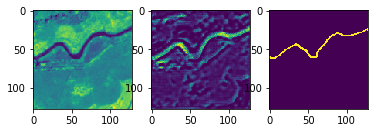

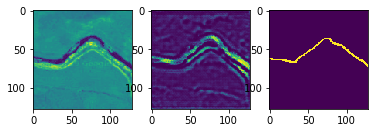

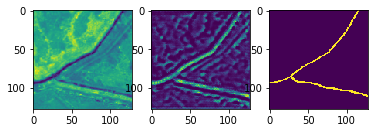

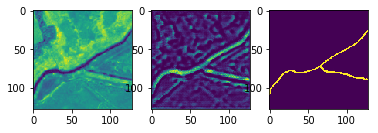

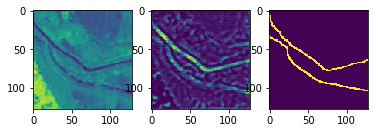

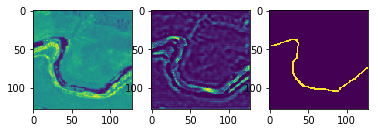

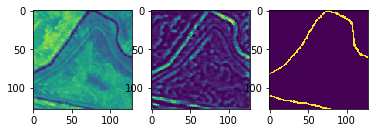

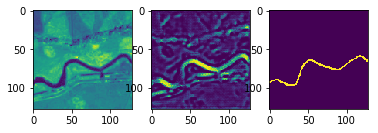

In [13]:
for i in range(images_in.shape[0]):
    plt.figure()
    plt.subplot(131)
    plt.imshow(images_in.squeeze()[i])
    plt.subplot(132)
    plt.imshow(Y_realworld.squeeze()[i])
    plt.subplot(133)
    plt.imshow(images_out.squeeze()[i])

(15, 107)
(109, 19)
(15, 69)
(19, 2)


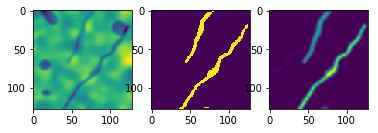

In [14]:
size_x=128
size_y=128
range_canvas = (0, 127)
mu_n_lines = 4
mu_n_noise = 4
mu_len_line = math.sqrt(size_x**2 + size_y**2) * 2
mu_len_noise = math.sqrt(size_x**2 + size_y**2) * 0.05
mu_color_background = 127
mu_color_line = 48
mu_color_noise = 48
mu_thickness_line = 2
mu_thickness_noise = 2
sigma_blur_background = 31
sigma_blur_lines = 7
sigma_blur_noise = 7
sigma_color_background = 255
sigma_color_line = 24
sigma_color_noise = 24
sigma_n_lines = 3
sigma_n_noise = 3
sigma_len_line = math.sqrt(size_x**2 + size_y**2) * 0.1
sigma_len_noise = math.sqrt(size_x**2 + size_y**2) * 0.02
sigma_thickness_line = 2
sigma_thickness_noise = 20
sigma_deformation = 2
points_deformation = 10
margin_ratio = 0.1
tresh_true = 12

n_lines = max(0, int(np.random.randn(1)) * sigma_n_lines + mu_n_lines)
image_random = np.random.randn(size_x, size_y)*sigma_color_background
image_random += mu_color_background
image_random[image_random < 0] = 0
image_blurred = cv2.GaussianBlur(image_random, (sigma_blur_background, sigma_blur_background), 0)

image_result = image_blurred
image_lines = np.zeros((size_x, size_y))
for line_n in range(n_lines):
    len_line = max(0, np.random.randn(1)[0]*sigma_len_line + mu_len_line)
    color_line = int(max(0, np.random.randn(1)[0]*sigma_color_line + mu_color_line))
    point_start = (int(np.random.rand(1)[0] * size_x * (1 + margin_ratio*2) - size_x*margin_ratio), \
                   int(np.random.rand(1)[0] * size_y * (1 + margin_ratio*2) - size_x*margin_ratio))
    phi = np.random.rand(1)[0] * math.pi * 2
    dx = int(math.cos(phi) * len_line)
    dy = int(math.sin(phi) * len_line)
    point_end = (point_start[0] + dx, point_start[1] + dy)
    thickness_line = int(max(0, np.random.rand(1)[0]*sigma_thickness_line + mu_thickness_line))
    
    image_line = np.zeros((size_x, size_y))
    cv2.line(image_line, point_start, point_end, color=(color_line,), thickness=thickness_line, lineType=cv2.LINE_AA)
    image_line = ed.deform_random_grid(image_line, sigma=sigma_deformation, points=points_deformation, prefilter=False)
    image_lines = np.maximum(image_lines, image_line)
image_lines_blurred = cv2.GaussianBlur(image_lines, (sigma_blur_lines, sigma_blur_lines), 0)

image_noise = np.zeros((size_x, size_y))
n_noise = max(0, int(np.random.randn(1)) * sigma_n_noise + mu_n_noise)
for noise_n in range(n_noise):
    len_noise = max(0, np.random.randn(1)[0]*sigma_len_noise + mu_len_noise)
    color_noise = int(max(0, np.random.randn(1)[0]*sigma_color_noise + mu_color_noise))
    point_start = (int(np.random.rand(1)[0] * size_x), \
                   int(np.random.rand(1)[0] * size_y))
    print(point_start)
    phi = np.random.rand(1)[0] * math.pi * 2
    dx = int(math.cos(phi) * len_noise)
    dy = int(math.sin(phi) * len_noise)
    point_end = (point_start[0] + dx, point_start[1] + dy)
    thickness_noise = int(max(0, np.random.rand(1)[0]*sigma_thickness_noise + mu_thickness_noise))
    
    image_bit = np.zeros((size_x, size_y))
    cv2.line(image_bit, point_start, point_end, color=(color_line,), thickness=thickness_noise, lineType=cv2.LINE_AA)
    image_bit = ed.deform_random_grid(image_bit, sigma=sigma_deformation, points=points_deformation, prefilter=False)
    image_noise = np.maximum(image_noise, image_bit)
image_noise_blurred = cv2.GaussianBlur(image_noise, (sigma_blur_noise, sigma_blur_noise), 0)

image_result = image_result - image_lines_blurred - image_noise_blurred
image_true = copy.deepcopy(image_lines)
image_true[image_true > tresh_true] = 255
image_true[image_true <= tresh_true] = 0

plt.figure()
plt.subplot(131)
plt.imshow(image_result)
plt.subplot(132)
plt.imshow(image_true)
plt.subplot(133)
plt.imshow(image_lines_blurred)

(array([15202.,   135.,    99.,    90.,   104.,   308.,    40.,    56.,
           72.,   278.]),
 array([ 0.        ,  6.09965611, 12.19931222, 18.29896833, 24.39862444,
        30.49828055, 36.59793666, 42.69759277, 48.79724888, 54.89690499,
        60.9965611 ]),
 <a list of 10 Patch objects>)

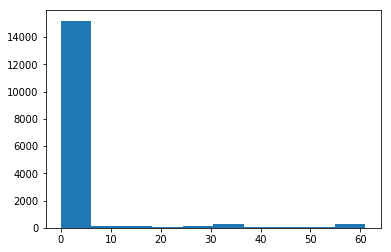

In [15]:
plt.hist(image_lines.flatten())